In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet

2024-11-27 17:10:35.710815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 17:10:36.559567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-27 17:10:36.559637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-11-27 17:10:36.559644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_025_SMOTE.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print("")
print(X_train_resampled.shape, Y_train_resampled.shape)
print(folds_train_resampled.shape)
print("")
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(2624, 100, 12) (2624,)
(2624,)

(4056, 100, 12) (4056,)
(4056,)

(7887, 100, 12) (7887,)


In [3]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

In [4]:
def k_fold_finetune_resnet(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, freeze_layers=8, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    layers_to_freeze_substrings = [f"_{i}_" for i in range(1, freeze_layers)]
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
        fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        if weights_path:
            fine_tuned_model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in fine_tuned_model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
        history = fine_tuned_model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=X_train.shape[0]//batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = fine_tuned_model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        
        
        print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc},Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            fine_tuned_model.save_weights(f'model-weights/fine-tuned/025/{name}')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
        
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')   
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")
    
    # load best model
    fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
    fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    fine_tuned_model.load_weights(f'model-weights/fine-tuned/025/{name}')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    y_pred = fine_tuned_model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")

# No Pretraining


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8395833373069763, Val Precision: 0.898876428604126, Val Recall: 0.5405405163764954, Val AUC: 0.9434833930315858, Val F1 Score: 0.6751054731857079
Test Accuracy: 0.9207556843757629, Test Precision: 0.9816201329231262, Test Recall: 0.70686274766922, Test AUC: 0.9422272859887927,Test F1 Score: 0.8218865732083055

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.8998144865036011, Val Precision: 0.9411764740943909, Val Recall: 0.6666666865348816, Val AUC: 0.9745604781997187, Val F1 Score: 0.7804878196994297
Test Accuracy: 0.9036388993263245, Test Precision: 0.9644412398338318, Test Recall: 0.6514706015586853, Test AUC: 0.9449033273305901,Test F1 Score: 0.7776477634338106

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9485294222831726, Val Precision: 0.7254902124404907, Val Recall: 1.0, Val AUC: 0.9948533640023002, Val

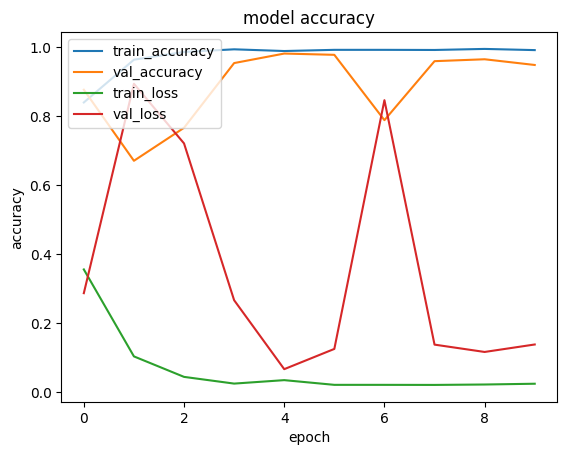

K-Fold Results:
Acuracy: 0.8953757166862488 	 +/- 0.035474162431556266
Precision: 0.8273294925689697 	 +/- 0.09301000996672681
Recall: 0.7420475006103515 	 +/- 0.19044370460107765
AUC: 0.9550032049819833 	 +/- 0.028385158309588036
F1: 0.7575525262168438 	 +/- 0.06677884985831947


247/247 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.898567259311676, Test Precision: 0.7707423567771912, Test Recall: 0.8651960492134094, Test AUC: 0.9372393501611352, Test F1 Score: 0.815242480527582


In [14]:
# no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="no_pretrain_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9166666865348816, Val Precision: 0.9090909361839294, Val Recall: 0.8108108043670654, Val AUC: 0.9827824812764572, Val F1 Score: 0.8571428655848208
Test Accuracy: 0.9464942216873169, Test Precision: 0.9499443769454956, Test Recall: 0.8372548818588257, Test AUC: 0.9595557634717988,Test F1 Score: 0.890046885565588

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9035250544548035, Val Precision: 0.859375, Val Recall: 0.7638888955116272, Val AUC: 0.972556258790436, Val F1 Score: 0.8088235331241647
Test Accuracy: 0.9164447784423828, Test Precision: 0.9581950902938843, Test Recall: 0.7078431248664856, Test AUC: 0.9407604704272678,Test F1 Score: 0.8142091829268875

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9797794222831726, Val Precision: 1.0, Val Recall: 0.8513513803482056, Val AUC: 0.9615296147211041, Val F1 Score

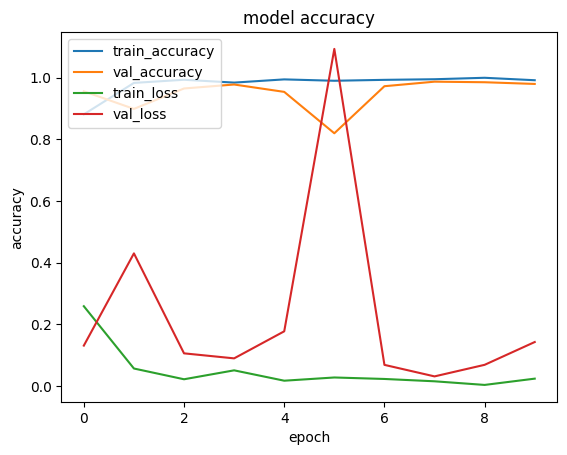

K-Fold Results:
Acuracy: 0.9174192309379577 	 +/- 0.03550467953210408
Precision: 0.8730024456977844 	 +/- 0.10948732291887445
Recall: 0.7811192989349365 	 +/- 0.06936494453651765
AUC: 0.9567501720835097 	 +/- 0.02215267113048147
F1: 0.8186409777602355 	 +/- 0.06404429263244468


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9097248911857605, Test Precision: 0.8755655884742737, Test Recall: 0.7588235139846802, Test AUC: 0.9234895890971405, Test F1 Score: 0.8130251915783299


In [ ]:
# smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="no_pretrain_smote.h5")

# Supervised Pretraining


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.862500011920929, Val Precision: 1.0, Val Recall: 0.5540540814399719, Val AUC: 0.9727898078801693, Val F1 Score: 0.7130435009399295
Test Accuracy: 0.9246861934661865, Test Precision: 0.9652509689331055, Test Recall: 0.7352941036224365, Test AUC: 0.9535654701422214,Test F1 Score: 0.8347245332412969

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9109461903572083, Val Precision: 0.7891566157341003, Val Recall: 0.9097222089767456, Val AUC: 0.96179676511955, Val F1 Score: 0.8451612784289421
Test Accuracy: 0.915303647518158, Test Precision: 0.8149678707122803, Test Recall: 0.8700980544090271, Test AUC: 0.9513355265143513,Test F1 Score: 0.8416311173838193

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 1.0, Val Precision: 1.0, Val Recall: 1.0, Val AUC: 1.0, Val F1 Score: 1.0
Test Accuracy: 0.9438316226005554, Test Precis

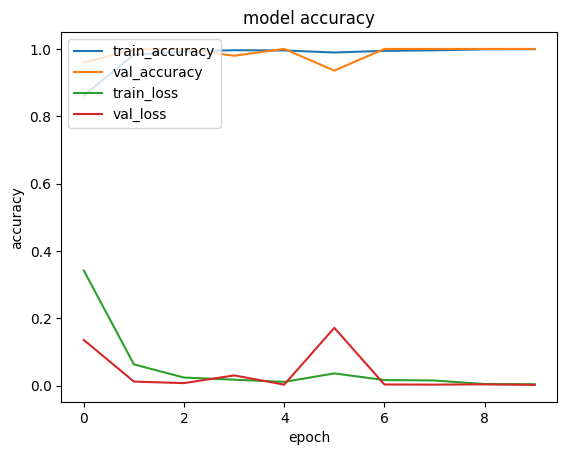

K-Fold Results:
Acuracy: 0.9132569670677185 	 +/- 0.05086437032657122
Precision: 0.8771587133407592 	 +/- 0.10643233025038253
Recall: 0.7727552652359009 	 +/- 0.1725207063517302
AUC: 0.9585432868253843 	 +/- 0.027097358504334867
F1: 0.8096180681561957 	 +/- 0.11699241425223292


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9438316226005554, Test Precision: 0.9508752226829529, Test Recall: 0.8254901766777039, Test AUC: 0.9842321099809856, Test F1 Score: 0.8837575375578853


In [16]:
# ptbxl no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="supervised_ptbxl_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9145833253860474, Val Precision: 0.8905109763145447, Val Recall: 0.8243243098258972, Val AUC: 0.9506064799739499, Val F1 Score: 0.8561403557248167
Test Accuracy: 0.9177126884460449, Test Precision: 0.8248481750488281, Test Recall: 0.865686297416687, Test AUC: 0.969037163351744,Test F1 Score: 0.8447739744076674

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.8794063329696655, Val Precision: 0.6908212304115295, Val Recall: 0.9930555820465088, Val AUC: 0.9507471870604782, Val F1 Score: 0.8148148059061207
Test Accuracy: 0.913528561592102, Test Precision: 0.8184803128242493, Test Recall: 0.8553921580314636, Test AUC: 0.957493536152275,Test F1 Score: 0.8365292497284307

Training on fold 3
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9944853186607361, Val Precision: 1.0, Val Recall: 0.9594594836235046, Val AUC: 0.9990224266820011, Val 

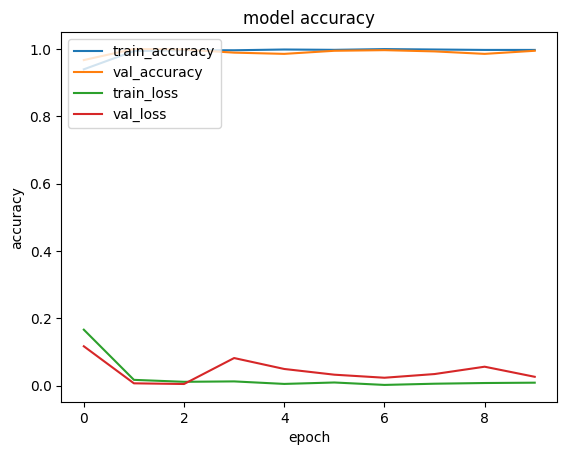

K-Fold Results:
Acuracy: 0.9350831747055054 	 +/- 0.03820575130704595
Precision: 0.8754331111907959 	 +/- 0.10389465710496788
Recall: 0.890670907497406 	 +/- 0.07199548227601898
AUC: 0.9639856820200743 	 +/- 0.019333938102348826
F1: 0.8764770545900978 	 +/- 0.05500351996835992


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9562571048736572, Test Precision: 0.9669421315193176, Test Recall: 0.8602941036224365, Test AUC: 0.9794401855149447, Test F1 Score: 0.9105058210775308


In [17]:
# ptbxl smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="supervised_ptbxl_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9208333492279053, Val Precision: 0.904411792755127, Val Recall: 0.8310810923576355, Val AUC: 0.9683327906219472, Val F1 Score: 0.8661972020878911
Test Accuracy: 0.9472549557685852, Test Precision: 0.9328358173370361, Test Recall: 0.8578431606292725, Test AUC: 0.9760612950499168,Test F1 Score: 0.8937691632493716

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.923933207988739, Val Precision: 0.9055117964744568, Val Recall: 0.7986111044883728, Val AUC: 0.9860232067510549, Val F1 Score: 0.8487084769544917
Test Accuracy: 0.9360973834991455, Test Precision: 0.9115755558013916, Test Recall: 0.8338235020637512, Test AUC: 0.9741111999785377,Test F1 Score: 0.870967723866796

Training on fold 3
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 1.0, Val Precision: 1.0, Val Recall: 1.0, Val AUC: 1.0, Val F1 Score: 1.0
Test Accuracy: 0.9444655776023

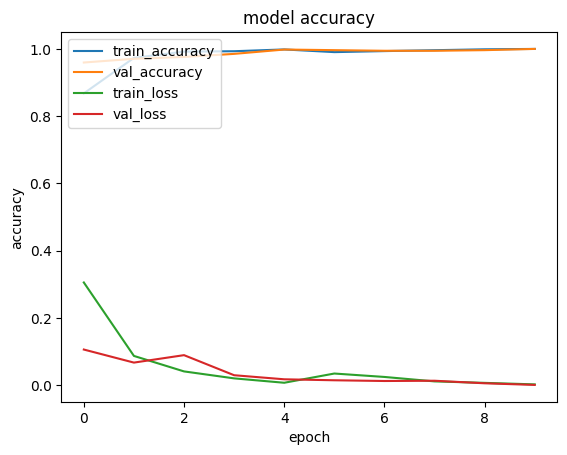

K-Fold Results:
Acuracy: 0.9391922354698181 	 +/- 0.03287566140619917
Precision: 0.9097756624221802 	 +/- 0.07730795410183623
Recall: 0.8436657071113587 	 +/- 0.08170900543336047
AUC: 0.9798712651263679 	 +/- 0.016949294773925445
F1: 0.8732169266164747 	 +/- 0.06743971505493807


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9444655776023865, Test Precision: 0.8614621162414551, Test Recall: 0.9357843399047852, Test AUC: 0.9737111708031938, Test F1 Score: 0.8970864903287301


In [11]:
# norm+rbbb no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="supervised_zhongshang_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9312499761581421, Val Precision: 0.8285714387893677, Val Recall: 0.9797297120094299, Val AUC: 0.9915947574080105, Val F1 Score: 0.8978328158954639
Test Accuracy: 0.9156840443611145, Test Precision: 0.7856252789497375, Test Recall: 0.9269607663154602, Test AUC: 0.9690285281206718,Test F1 Score: 0.8504609886614786

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9573283791542053, Val Precision: 1.0, Val Recall: 0.8402777910232544, Val AUC: 0.9964135021097047, Val F1 Score: 0.9132075549920456
Test Accuracy: 0.9449727535247803, Test Precision: 0.9402412176132202, Test Recall: 0.8406862616539001, Test AUC: 0.9781211749279837,Test F1 Score: 0.8876811475933327

Training on fold 3
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9963235259056091, Val Precision: 1.0, Val Recall: 0.9729729890823364, Val AUC: 0.9999712478435884, Val F1 Score: 0

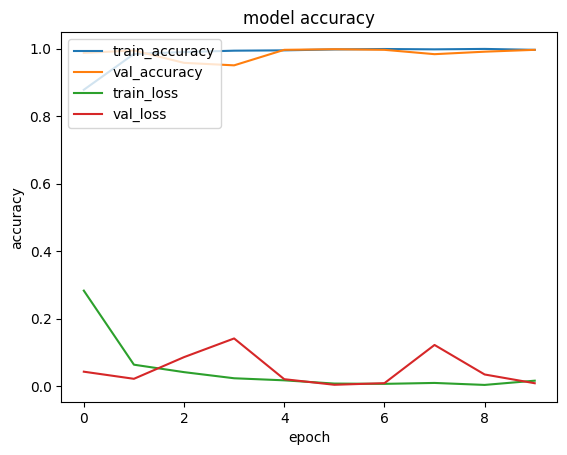

K-Fold Results:
Acuracy: 0.9494855999946594 	 +/- 0.029475813885583194
Precision: 0.9042391419410706 	 +/- 0.08198409319701397
Recall: 0.893596088886261 	 +/- 0.07831804636286807
AUC: 0.9808018234196817 	 +/- 0.02713277920738951
F1: 0.8961446003820782 	 +/- 0.06227847780595964


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9575250148773193, Test Precision: 0.896696150302887, Test Recall: 0.9446078538894653, Test AUC: 0.9856266578805286, Test F1 Score: 0.9200286581683561


In [19]:
# norm+rbbb smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="supervised_zhongshang_smote.h5")

# SimCLR Pretraining


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9375, Val Precision: 1.0, Val Recall: 0.7972972989082336, Val AUC: 0.996336698143927, Val F1 Score: 0.8872180461101801
Test Accuracy: 0.9509319067001343, Test Precision: 0.9479674696922302, Test Recall: 0.8573529124259949, Test AUC: 0.9700271967860172,Test F1 Score: 0.9003860800287696

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9870129823684692, Val Precision: 0.9597315192222595, Val Recall: 0.9930555820465088, Val AUC: 0.9983473980309423, Val F1 Score: 0.9761092151934154
Test Accuracy: 0.9245594143867493, Test Precision: 0.8585608005523682, Test Recall: 0.8480392098426819, Test AUC: 0.9576096506671763,Test F1 Score: 0.8532675711560426

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9963235259056091, Val Precision: 1.0, Val Recall: 0.9729729890823364, Val AUC: 0.9986774008050604, Val F1 Score: 0.986301378139

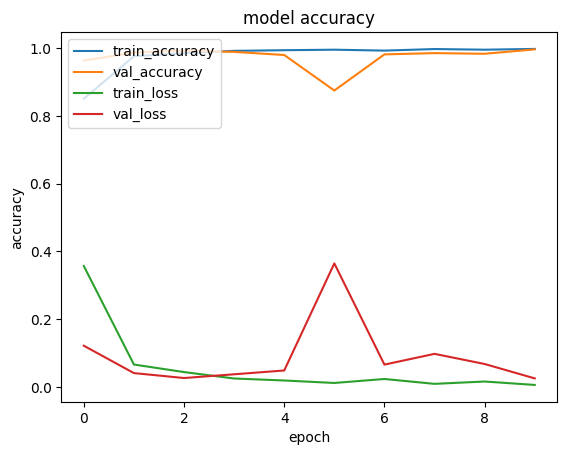

K-Fold Results:
Acuracy: 0.9415517807006836 	 +/- 0.0447742963345834
Precision: 0.9073696136474609 	 +/- 0.11997545215870423
Recall: 0.846150028705597 	 +/- 0.12385505464658805
AUC: 0.9719904213552033 	 +/- 0.03334403111702197
F1: 0.8695666477831974 	 +/- 0.10443587167747281


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9410422444343567, Test Precision: 0.9120879173278809, Test Recall: 0.854411780834198, Test AUC: 0.9543955841272715, Test F1 Score: 0.8823082874367609


In [20]:
# ptbxl no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.001, num_classes=1, name="simclr_ptbxl_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9416666626930237, Val Precision: 0.8409090638160706, Val Recall: 1.0, Val AUC: 0.9954005210029306, Val F1 Score: 0.9135802309245273
Test Accuracy: 0.944212019443512, Test Precision: 0.8499562740325928, Test Recall: 0.9524509906768799, Test AUC: 0.9855159927832943,Test F1 Score: 0.8982894277946237

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9888682961463928, Val Precision: 0.9599999785423279, Val Recall: 1.0, Val AUC: 0.9997011251758088, Val F1 Score: 0.9795918255634776
Test Accuracy: 0.9405350685119629, Test Precision: 0.8826107978820801, Test Recall: 0.8882352709770203, Test AUC: 0.9720860706177459,Test F1 Score: 0.8854141023438789

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.998161792755127, Val Precision: 1.0, Val Recall: 0.9864864945411682, Val AUC: 0.9998562392179414, Val F1 Score: 0.9931972829938855

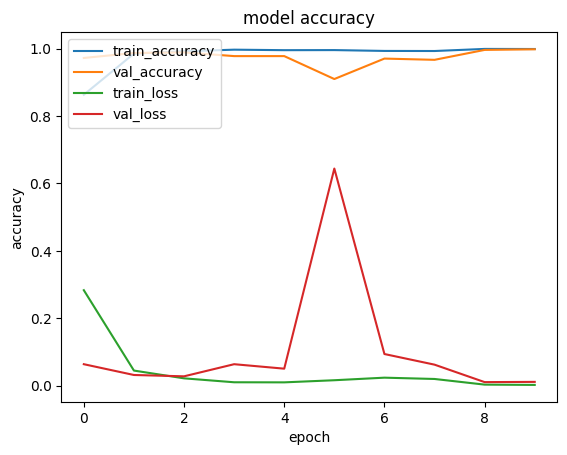

K-Fold Results:
Acuracy: 0.9450099229812622 	 +/- 0.043395009288965156
Precision: 0.882364284992218 	 +/- 0.10864516999848618
Recall: 0.8926003336906433 	 +/- 0.13586987784413726
AUC: 0.9797185106643228 	 +/- 0.024596806184095505
F1: 0.8806719330709096 	 +/- 0.1034685625617549


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.9562571048736572, Test Precision: 0.9568732976913452, Test Recall: 0.8700980544090271, Test AUC: 0.9787855846973645, Test F1 Score: 0.9114249040413507


In [21]:
# ptbxl smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.001, num_classes=1, name="simclr_ptbxl_smote.h5")


Training on fold 1
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.8958333134651184, Val Precision: 1.0, Val Recall: 0.662162184715271, Val AUC: 0.9628785411917943, Val F1 Score: 0.7967479838060443
Test Accuracy: 0.9041460752487183, Test Precision: 0.8958076238632202, Test Recall: 0.7122548818588257, Test AUC: 0.9093627702491976,Test F1 Score: 0.7935554134650277

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8775510191917419, Val Precision: 1.0, Val Recall: 0.5416666865348816, Val AUC: 0.9859528832630098, Val F1 Score: 0.7027027194216094
Test Accuracy: 0.8937492370605469, Test Precision: 0.9539275169372559, Test Recall: 0.6191176176071167, Test AUC: 0.9118477885424735,Test F1 Score: 0.7508917814073145

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9503676295280457, Val Precision: 0.7326732873916626, Val Recall: 1.0, Val AUC: 0.9994537090281771, Val F1 Score: 0.845714299081296

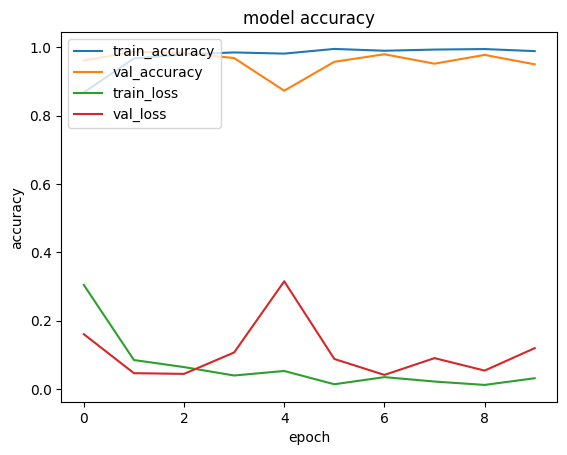

K-Fold Results:
Acuracy: 0.8991273522377015 	 +/- 0.02645881374694739
Precision: 0.8664121150970459 	 +/- 0.11274648392307182
Recall: 0.692432451248169 	 +/- 0.15996931172733755
AUC: 0.9590740662091302 	 +/- 0.034816613330188255
F1: 0.7507139211938645 	 +/- 0.06207133589915675


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.8943831324577332, Test Precision: 0.7474374771118164, Test Recall: 0.8936274647712708, Test AUC: 0.9425920616236917, Test F1 Score: 0.8140209941722732


In [22]:
# BARD no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='models/simclr-bard_epoch_3.h5', learning_rate=0.001, num_classes=1, name="simclr_bard_no_smote.h5")


Training on fold 1
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9208333492279053, Val Precision: 1.0, Val Recall: 0.7432432174682617, Val AUC: 0.965076522305438, Val F1 Score: 0.8527131613311939
Test Accuracy: 0.8995816111564636, Test Precision: 0.945078432559967, Test Recall: 0.6495097875595093, Test AUC: 0.9003169465152232,Test F1 Score: 0.7699011998384206

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8831169009208679, Val Precision: 0.7612903118133545, Val Recall: 0.8194444179534912, Val AUC: 0.9458333333333334, Val F1 Score: 0.7892976407870032
Test Accuracy: 0.8998351693153381, Test Precision: 0.8045808672904968, Test Recall: 0.8093137145042419, Test AUC: 0.9348792912068197,Test F1 Score: 0.8069403512115307

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9522058963775635, Val Precision: 0.7790697813034058, Val Recall: 0.9054054021835327, Val AUC: 0.9830937320299022, Va

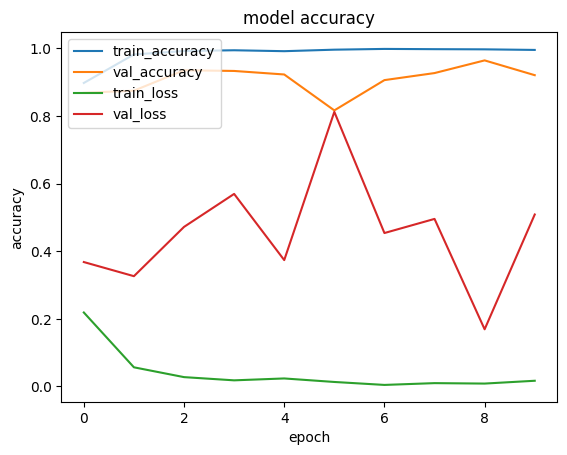

K-Fold Results:
Acuracy: 0.921448826789856 	 +/- 0.022137411960945198
Precision: 0.8729536890983581 	 +/- 0.0903992502933803
Recall: 0.7840731620788575 	 +/- 0.06979347419490269
AUC: 0.9650534884245132 	 +/- 0.012862420829316103
F1: 0.8193230125420913 	 +/- 0.022890741202067088


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.8995816111564636, Test Precision: 0.945078432559967, Test Recall: 0.6495097875595093, Test AUC: 0.9003169465152232, Test F1 Score: 0.7699011998384206


In [23]:
# BARD smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='models/simclr-bard_epoch_3.h5', learning_rate=0.001, num_classes=1, name="simclr_bard_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9229166507720947, Val Precision: 0.8535031676292419, Val Recall: 0.9054054021835327, Val AUC: 0.9787324975577987, Val F1 Score: 0.8786885140192697
Test Accuracy: 0.9222771525382996, Test Precision: 0.8376715779304504, Test Recall: 0.8676470518112183, Test AUC: 0.9545776365959415,Test F1 Score: 0.8523958658535347

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9406307935714722, Val Precision: 0.8333333134651184, Val Recall: 0.9722222089767456, Val AUC: 0.9890998593530239, Val F1 Score: 0.8974358802716408
Test Accuracy: 0.9206289052963257, Test Precision: 0.8618218898773193, Test Recall: 0.8254901766777039, Test AUC: 0.9542234244475968,Test F1 Score: 0.8432648805648085

Training on fold 3
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9595588445663452, Val Precision: 0.7708333134651184, Val Recall: 1.0, Val AUC: 1.0, Val F1 Score: 0

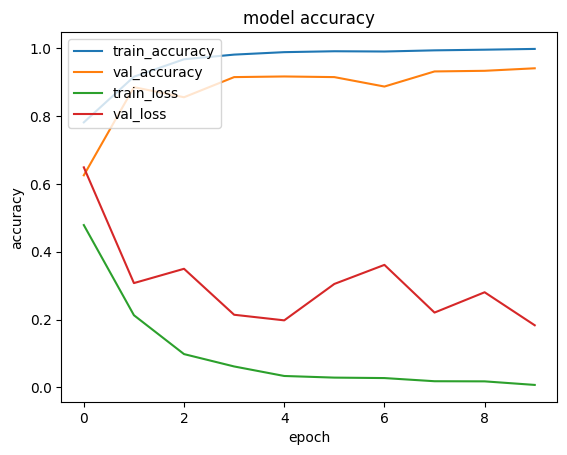

K-Fold Results:
Acuracy: 0.9276832222938538 	 +/- 0.020565251193306492
Precision: 0.8387785434722901 	 +/- 0.03984094265198442
Recall: 0.8476467370986939 	 +/- 0.14316896574755317
AUC: 0.9588271870145174 	 +/- 0.038454671496688846
F1: 0.8337327696650437 	 +/- 0.061296148012089255


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9206289052963257, Test Precision: 0.8618218898773193, Test Recall: 0.8254901766777039, Test AUC: 0.9542234244475968, Test F1 Score: 0.8432648805648085


In [15]:
# norm+rbbb no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="simclr_zhongshang_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8916666507720947, Val Precision: 0.7891566157341003, Val Recall: 0.8851351141929626, Val AUC: 0.9662670954086616, Val F1 Score: 0.8343948891324501
Test Accuracy: 0.8950170874595642, Test Precision: 0.7863894104957581, Test Recall: 0.8156862854957581, Test AUC: 0.9183121812090664,Test F1 Score: 0.8007699746090906

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9573283791542053, Val Precision: 0.9416058659553528, Val Recall: 0.8958333134651184, Val AUC: 0.9918776371308017, Val F1 Score: 0.9181494683737209
Test Accuracy: 0.9173322916030884, Test Precision: 0.8938705921173096, Test Recall: 0.7720588445663452, Test AUC: 0.9340357213519922,Test F1 Score: 0.8285113178811939

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9779411554336548, Val Precision: 0.8690476417541504, Val Recall: 0.9864864945411682, Val AUC: 0.997

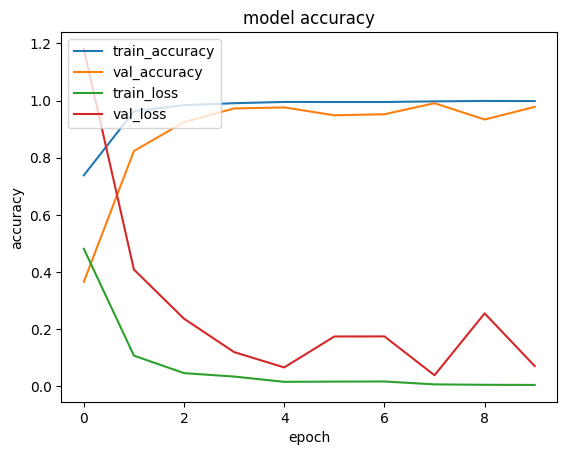

K-Fold Results:
Acuracy: 0.9288635134696961 	 +/- 0.041616437022310236
Precision: 0.8790099263191223 	 +/- 0.0666566748928804
Recall: 0.814854621887207 	 +/- 0.15878382530279922
AUC: 0.9611050236232126 	 +/- 0.04730884442274721
F1: 0.8367547519926125 	 +/- 0.10257432947088341


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9288703203201294, Test Precision: 0.8782608509063721, Test Recall: 0.8416666388511658, Test AUC: 0.952718462962404, Test F1 Score: 0.8595744446425915


In [17]:
# norm+rbbb smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="simclr_zhongshang_smote.h5")

# MoCo v2 Pretraining


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8979166746139526, Val Precision: 0.9900990128517151, Val Recall: 0.6756756901741028, Val AUC: 0.9607009117551286, Val F1 Score: 0.8032128626207284
Test Accuracy: 0.9215164184570312, Test Precision: 0.9191740155220032, Test Recall: 0.7637255191802979, Test AUC: 0.9180306978272754,Test F1 Score: 0.8342704216693028

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9461966753005981, Val Precision: 0.8616352081298828, Val Recall: 0.9513888955116272, Val AUC: 0.9716947960618847, Val F1 Score: 0.9042904254280226
Test Accuracy: 0.9347026944160461, Test Precision: 0.8888322114944458, Test Recall: 0.854411780834198, Test AUC: 0.9506893094162584,Test F1 Score: 0.8712821796922587

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9577205777168274, Val Precision: 0.8399999737739563, Val Recall: 0.8513513803482056, Val AUC: 0.9797

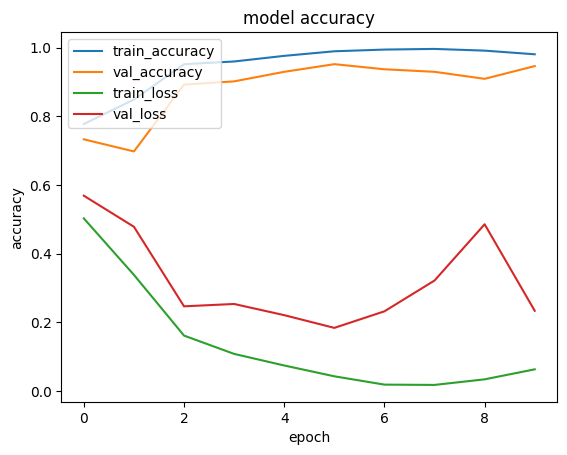

K-Fold Results:
Acuracy: 0.9151175498962403 	 +/- 0.03096909442670461
Precision: 0.8802845001220703 	 +/- 0.059716951302235324
Recall: 0.7246225953102112 	 +/- 0.1541710442202173
AUC: 0.9448636822841883 	 +/- 0.032731223623376396
F1: 0.7848529629762832 	 +/- 0.09031476130361132


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.9347026944160461, Test Precision: 0.8888322114944458, Test Recall: 0.854411780834198, Test AUC: 0.9506893094162584, Test F1 Score: 0.8712821796922587


In [26]:
# ptbxl no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.001, num_classes=1, name="moco_ptbxl_no_smote.h5")


Training on fold 1
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.8604166507720947, Val Precision: 0.7755101919174194, Val Recall: 0.7702702879905701, Val AUC: 0.9367062845978509, Val F1 Score: 0.7728813588115817
Test Accuracy: 0.9225307703018188, Test Precision: 0.8782424330711365, Test Recall: 0.8132352828979492, Test AUC: 0.9508791168254545,Test F1 Score: 0.8444896752333476

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9610389471054077, Val Precision: 0.8819875717163086, Val Recall: 0.9861111044883728, Val AUC: 0.9933192686357244, Val F1 Score: 0.9311475347300044
Test Accuracy: 0.941169023513794, Test Precision: 0.8975781798362732, Test Recall: 0.8720588088035583, Test AUC: 0.9596752314744952,Test F1 Score: 0.8846344909615756

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9319853186607361, Val Precision: 0.7078651785850525, Val Recall: 0.8513513803482056, Val AUC: 0.9605

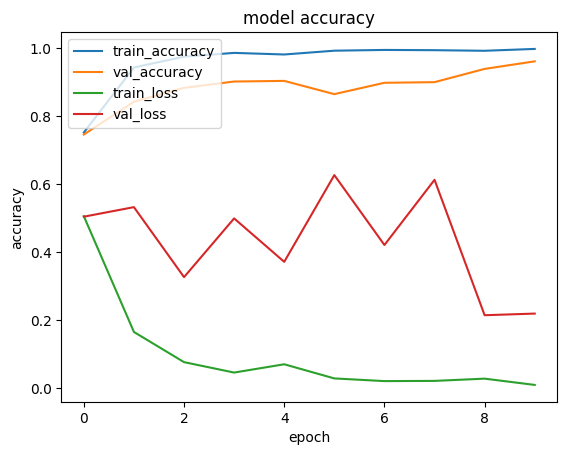

K-Fold Results:
Acuracy: 0.9156511545181274 	 +/- 0.035545011297934415
Precision: 0.8244239330291748 	 +/- 0.07536750263917355
Recall: 0.8039708018302918 	 +/- 0.13754264173749733
AUC: 0.9540183454676242 	 +/- 0.023055242313961034
F1: 0.8039389859649522 	 +/- 0.07760674617082149


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.941169023513794, Test Precision: 0.8975781798362732, Test Recall: 0.8720588088035583, Test AUC: 0.9596752314744952, Test F1 Score: 0.8846344909615756


In [27]:
# ptbxl smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.001, num_classes=1, name="moco_ptbxl_smote.h5")

In [7]:
# BARD no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_4.h5', learning_rate=0.001, num_classes=1, name="moco_bard_no_smote.h5")


Training on fold 1
15/15 [==============================] - 0s 3ms/step


ZeroDivisionError: float division by zero

In [8]:
# BARD smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_5.h5', learning_rate=0.001, num_classes=1, name="moco_bard_smote.h5")


Training on fold 1
15/15 [==============================] - 0s 3ms/step


ZeroDivisionError: float division by zero


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8958333134651184, Val Precision: 1.0, Val Recall: 0.662162184715271, Val AUC: 0.933714588082058, Val F1 Score: 0.7967479838060443
Test Accuracy: 0.9197413325309753, Test Precision: 0.9405134916305542, Test Recall: 0.7362744808197021, Test AUC: 0.9303890548865347,Test F1 Score: 0.8259554506969778

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9128015041351318, Val Precision: 0.8646616339683533, Val Recall: 0.7986111044883728, Val AUC: 0.9531821378340366, Val F1 Score: 0.8303248968691654
Test Accuracy: 0.9083301424980164, Test Precision: 0.885764479637146, Test Recall: 0.7411764860153198, Test AUC: 0.902594803099964,Test F1 Score: 0.8070456375672652

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9650735259056091, Val Precision: 0.9104477763175964, Val Recall: 0.8243243098258972, Val AUC: 0.9941058079355952, Val 

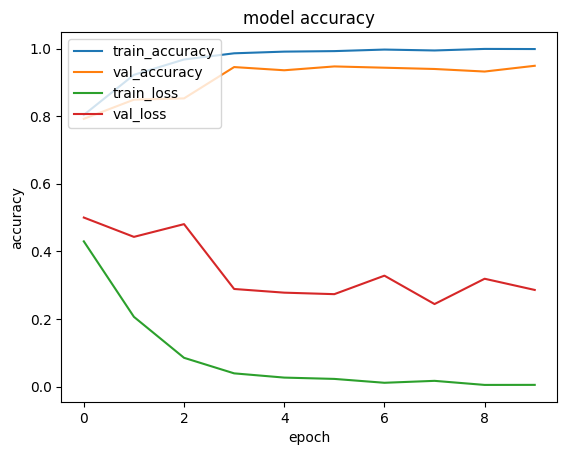

K-Fold Results:
Acuracy: 0.9257367372512817 	 +/- 0.026597734558336167
Precision: 0.9276260256767273 	 +/- 0.04632832858032982
Recall: 0.7452013373374939 	 +/- 0.07370352591294542
AUC: 0.9392103892922925 	 +/- 0.05536719312740203
F1: 0.8230548608398726 	 +/- 0.041635335502057016


247/247 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9160643815994263, Test Precision: 0.8596033453941345, Test Recall: 0.8073529601097107, Test AUC: 0.9291201789421087, Test F1 Score: 0.8326592642323626


In [9]:
# norm+rbbb no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="moco_zhongshang_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8729166388511658, Val Precision: 0.9484536051750183, Val Recall: 0.6216216087341309, Val AUC: 0.9394334093129274, Val F1 Score: 0.7510203977943906
Test Accuracy: 0.9212628602981567, Test Precision: 0.8625447154045105, Test Recall: 0.8274509906768799, Test AUC: 0.9404249120547826,Test F1 Score: 0.8446334824358389

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9684600830078125, Val Precision: 0.9319728016853333, Val Recall: 0.9513888955116272, Val AUC: 0.9949367088607596, Val F1 Score: 0.941580765672287
Test Accuracy: 0.93635094165802, Test Precision: 0.8959835171699524, Test Recall: 0.8529411554336548, Test AUC: 0.946777298229023,Test F1 Score: 0.8739326837293231

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9742646813392639, Val Precision: 0.9411764740943909, Val Recall: 0.8648648858070374, Val AUC: 0.9892754

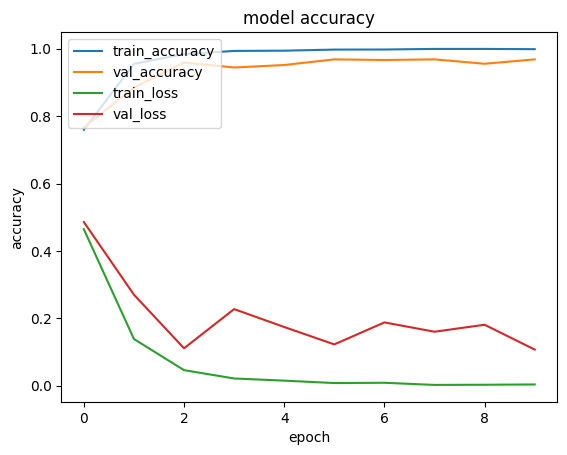

K-Fold Results:
Acuracy: 0.9295886158943176 	 +/- 0.03838892180315456
Precision: 0.909375524520874 	 +/- 0.03990327381309592
Recall: 0.7809084177017211 	 +/- 0.12239299936836076
AUC: 0.9528937473880047 	 +/- 0.045102299575828196
F1: 0.8349466797443672 	 +/- 0.07597886915152802


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.93635094165802, Test Precision: 0.8959835171699524, Test Recall: 0.8529411554336548, Test AUC: 0.946777298229023, Test F1 Score: 0.8739326837293231


In [10]:
# norm+rbbb smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="moco_zhongshang_smote.h5")

In [18]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

alpha = .95
y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
y_pred_2 = np.array([0.18, 0.25, 0.55, 0.35, 0.87, 0.79, 0.88, 0.99, 0.01])
y_true = np.array([0,    1,    0,    0,    1,    1,    0,    1,    0   ])

print(y_pred.shape, y_pred_2.shape, y_true.shape)

# type of y_true
print(y_true.dtype)

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

p_value = delong_roc_test(y_true, y_pred, y_pred_2)
print('P value:', p_value)
       

(9,) (9,) (9,)
int64
AUC: 0.8
AUC COV: 0.028749999999999998
95% AUC CI: [0.46767194 1.        ]
P value: [[-0.31921128]]


/tmp/ipykernel_4325/3748613858.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_4325/3748613858.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/tmp/ipykernel_4325/3748613858.py:64: DeprecationWarning: `np.float` is a deprecated alias for t

In [ ]:
models = ["no_pretrain_no_smote.h5", "no_pretrain_smote.h5", "supervised_ptbxl_no_smote.h5", "supervised_ptbxl_smote.h5", "supervised_zhongshang_no_smote.h5", "supervised_zhongshang_smote.h5", "simclr_ptbxl_no_smote.h5", "simclr_ptbxl_smote.h5", "simclr_zhongshang_no_smote.h5", "simclr_zhongshang_smote.h5", "moco_ptbxl_no_smote.h5", "moco_ptbxl_smote.h5", "moco_zhongshang_no_smote.h5", "moco_zhongshang_smote.h5", "simclr_bard_no_smote.h5", "simclr_bard_smote.h5"]#, "moco_bard_no_smote.h5", "moco_bard_smote.h5"]

# create a dataframe to store the predictions of each model
df = pd.DataFrame()
df['y_true'] = Y_test

X_input = keras.Input(shape=X_test.shape[1:])
model, _ = resnet.model(X_input, num_classes=1, filters=[16, 16], kernels=[5, 3], layers=10, hidden_units=128)
model = keras.Model(inputs=X_input, outputs=model)

# load each model and get predictions
for path in models:
    # remove folders and extensions from path
    trimmed_path = path.split('/')[-1].split('.h5')[0]
    print(trimmed_path)
    model.load_weights('model-weights/fine-tuned/025/' + path)
    preds = model.predict(X_test)
    preds = preds.reshape(preds.shape[0])
    df[trimmed_path] = preds

no_pretrain_no_smote
247/247 [==============================] - 1s 4ms/step
no_pretrain_smote
247/247 [==============================] - 1s 4ms/step
supervised_ptbxl_no_smote
247/247 [==============================] - 1s 4ms/step
supervised_ptbxl_smote
247/247 [==============================] - 1s 4ms/step
supervised_zhongshang_no_smote
247/247 [==============================] - 1s 5ms/step
supervised_zhongshang_smote
247/247 [==============================] - 1s 4ms/step
simclr_ptbxl_no_smote
247/247 [==============================] - 1s 4ms/step
simclr_ptbxl_smote
247/247 [==============================] - 1s 4ms/step
simclr_zhongshang_no_smote
247/247 [==============================] - 1s 4ms/step
simclr_zhongshang_smote
247/247 [==============================] - 1s 4ms/step
moco_ptbxl_no_smote
247/247 [==============================] - 1s 4ms/step
moco_ptbxl_smote
247/247 [==============================] - 1s 4ms/step
moco_zhongshang_no_smote
247/247 [==============================

In [27]:
# baseline model (no_pretrain_no_smote.h5)
X_input = keras.Input(shape=X_test.shape[1:])
model, _ = resnet.model(X_input, num_classes=1, filters=[16, 16], kernels=[5, 3], layers=10, hidden_units=128)
model = keras.Model(inputs=X_input, outputs=model)
model.load_weights('model-weights/fine-tuned/025/no_pretrain_no_smote.h5')
preds = model.predict(X_test)
preds = preds.reshape(preds.shape[0])
df['baseline'] = preds
df['y_true'] = Y_test


247/247 [==============================] - 1s 4ms/step


In [28]:
for model in models:
    key = model.split('.h5')[0]
    p_value = delong_roc_test(df['y_true'], df['baseline'], df[key])
    print(f"p-value for baseline vs {model}: {10**p_value}")
    statiscally_significant = 10**p_value < 0.05

/tmp/ipykernel_4325/3748613858.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_4325/3748613858.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/tmp/ipykernel_4325/3748613858.py:64: DeprecationWarning: `np.float` is a deprecated alias for t

p-value for baseline vs no_pretrain_no_smote.h5: [[nan]]
p-value for baseline vs no_pretrain_smote.h5: [[5.78204863e-06]]
p-value for baseline vs supervised_ptbxl_no_smote.h5: [[2.19264043e-34]]
p-value for baseline vs supervised_ptbxl_smote.h5: [[2.67046636e-29]]
p-value for baseline vs supervised_zhongshang_no_smote.h5: [[6.98869708e-18]]
p-value for baseline vs supervised_zhongshang_smote.h5: [[3.07693366e-38]]
p-value for baseline vs simclr_ptbxl_no_smote.h5: [[4.27264259e-06]]
p-value for baseline vs simclr_ptbxl_smote.h5: [[3.24699641e-32]]
p-value for baseline vs simclr_zhongshang_no_smote.h5: [[6.05279563e-07]]
p-value for baseline vs simclr_zhongshang_smote.h5: [[1.89650167e-05]]
p-value for baseline vs moco_ptbxl_no_smote.h5: [[9.60270925e-05]]
p-value for baseline vs moco_ptbxl_smote.h5: [[1.46878405e-13]]
p-value for baseline vs moco_zhongshang_no_smote.h5: [[0.03863613]]
p-value for baseline vs moco_zhongshang_smote.h5: [[0.01041845]]
p-value for baseline vs simclr_bard_no